# Probability density function plot

In this notebook, we present a simple way to make a probability density function plot. This will be calculated for precipitation over the tropics, tropical ocean and tropical land.

### Calling packages

In [1]:
import intake
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import seaborn as sns
import pandas as pd
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import datashader as ds
import datashader.transfer_functions as tf

from datashader.mpl_ext import dsshow
import cartopy as cartopy

### Defining functions

In [2]:
def get_nest(ds):
    return ds.crs.healpix_order == "nest"

def get_nside(ds):
    return ds.crs.healpix_nside

def attach_coords(ds):
    lons, lats = hp.pix2ang(get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True)
    return ds.assign_coords(
        lat = (("cell",), lats, {"units": "degree_north"}),
        lon = (("cell",), lons, {"units": "degree_east"}),
    )

def read_dataset(catalog,exp_name='ngc3028',zoom=5,time_resolution="P1D"):
    exp = catalog[exp_name](time=time_resolution, zoom=zoom, chunks="auto").to_dask()
    return attach_coords(exp)


In [3]:
def histograms_bins(fld,bins):
    counts_per_bin, bin_edges = np.histogram(fld, bins,density=True)
    return counts_per_bin, bin_edges

In [4]:
def get_domain(var, ds, domain_name):

    domains = {
        "Tropics": ds[var]
        .where((ds["lat"] >= -30.1) & (ds["lat"] <= 30),drop=True),
        "Tropics_ocean": ds[var]
        .where(is_ocean==True)
        .where((ds["lat"] >= -30.1) & (ds["lat"] <= 30),drop=True),
        "Tropics_land": ds[var]
        .where(is_ocean==False)
        .where((ds["lat"] >= -30.1) & (ds["lat"] <= 30),drop=True)
    }
    return domains[domain_name]

### General settings 

In [7]:
cat = intake.open_catalog("/work/bm1235/k203123/NextGEMS_Cycle3.git/experiments/catalog.yaml")
var = 'pr'
t1,t2 = '2020-02-01','2021-01-31'
sns.set_context('talk')######appereance of plots for talks

In [8]:
#####transform pr units from kg m-2 s-1 to mm d-1
processing_properties = {
    "pr": dict(time_scale=86400),
    "default": dict(time_scale=1),
}

if var == 'pr':
    var_properties = 'pr'
else:
    var_properties = 'default'

### Computing PDF

In [10]:
%%time
ds_3028 = read_dataset(cat,exp_name='ngc3028',zoom=6,time_resolution="P1D")

CPU times: user 554 ms, sys: 100 ms, total: 655 ms
Wall time: 1.2 s


In [11]:
####Compute the land-sea mask
is_ocean = np.isfinite(ds_3028.atmos_fluxes_heatflux_sensible)

In [13]:
%%time
domain = 'Tropics'
pr_tropics = (
    get_domain(var, ds_3028, domain)
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

CPU times: user 35.2 ms, sys: 3.52 ms, total: 38.7 ms
Wall time: 48.4 ms


In [14]:
%%time
domain = 'Tropics_ocean'
pr_tropics_ocean = (
    get_domain(var, ds_3028, domain)
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

CPU times: user 35.1 ms, sys: 15 µs, total: 35.1 ms
Wall time: 34.5 ms


In [15]:
%%time
domain = 'Tropics_land'
pr_tropics_land = (
    get_domain(var, ds_3028, domain)
    .sel(time=slice(t1,t2))
    * processing_properties[var_properties]["time_scale"])

CPU times: user 32.1 ms, sys: 2.85 ms, total: 34.9 ms
Wall time: 33.9 ms


**Calculating histogram based on bins**

In [21]:
%%time
bins = [0,0.1,1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,225,250]
histogram_tropics = histograms_bins(pr_tropics,bins)

CPU times: user 1.16 s, sys: 334 ms, total: 1.49 s
Wall time: 5.69 s


In [22]:
%%time
histogram_tropics_ocean = histograms_bins(pr_tropics_ocean,bins)

CPU times: user 1.28 s, sys: 516 ms, total: 1.8 s
Wall time: 6.4 s


In [23]:
%%time
histogram_tropics_land = histograms_bins(pr_tropics_land,bins)

CPU times: user 879 ms, sys: 448 ms, total: 1.33 s
Wall time: 1.58 s


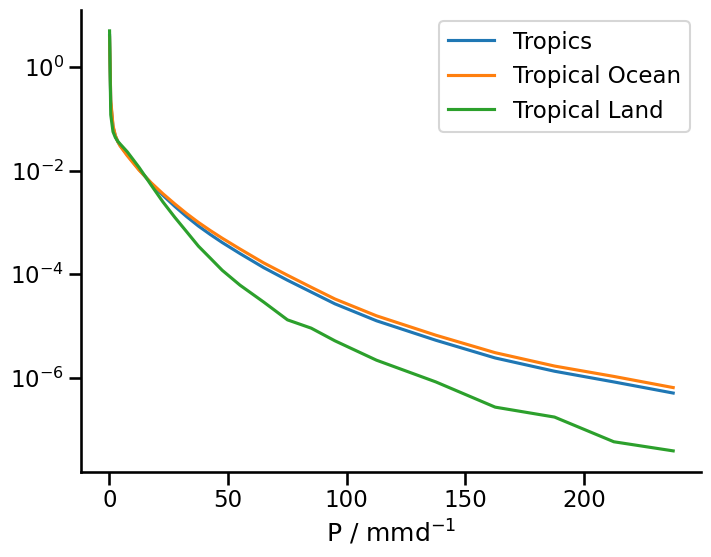

In [28]:
xaxis= (np.array(bins[1:]) - np.array(bins[:-1]))/2+np.array(bins[:-1])
fig = plt.figure(figsize=(8, 6),facecolor='white')
ax = fig.add_subplot(111)
plt.plot(xaxis,histogram_tropics[0],label='Tropics')
plt.plot(xaxis,histogram_tropics_ocean[0],label='Tropical Ocean')
plt.plot(xaxis,histogram_tropics_land[0],label='Tropical Land')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yscale('log')
ax.set_xlabel('P / mmd$^{-1}$')
plt.legend()